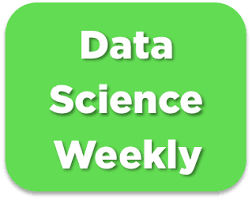

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [1]:
!pip install plotly
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import  OneHotEncoder, StandardScaler

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, GridSearchCV


from sklearn.impute import KNNImputer
!pip install xgboost
!pip install plotly
!pip install s3fs

from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostClassifier


import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

# Read file with labels

In [2]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [4]:
data.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


# Explore dataset

In [4]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

In [6]:
data_sample.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,10000,10000.000000,10000.000000,10000,10000.000000,10000.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,5485,NaN,NaN,4844,NaN,NaN
mean,NaN,30.507300,0.679000,NaN,4.851400,0.032900
std,NaN,8.181103,0.466884,NaN,3.340843,0.178384
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [7]:
data_sample.groupby('country').count()

,age,new_user,source,total_pages_visited,converted
country,,,,,
China,2529,2529,2529,2529,2529
Germany,374,374,374,374,374
UK,1612,1612,1612,1612,1612
US,5485,5485,5485,5485,5485


In [8]:
"""#Remplacer pays par continent car peu d'allemands
data_sample['country'] = data_sample['country'].replace('Germany','EU').replace('UK','EU').replace('China','Asia').rename('continent').astype(str)
data_sample = data_sample.rename(columns={'country':'continent'})"""

"#Remplacer pays par continent car peu d'allemands\ndata_sample['country'] = data_sample['country'].replace('Germany','EU').replace('UK','EU').replace('China','Asia').rename('continent').astype(str)\ndata_sample = data_sample.rename(columns={'country':'continent'})"

In [9]:
data_sample.head()

,country,age,new_user,source,total_pages_visited,converted
218784,US,26,0,Ads,4,0
115683,US,23,1,Seo,7,0
11591,US,45,1,Ads,2,0
205801,UK,30,0,Seo,1,0
267134,China,26,1,Seo,4,0


In [10]:
"""for i in data_sample[['age','total_pages_visited']]:
    for a in data_sample.loc[:,i].index:
        
        Moyenne = data_sample[i].mean()
        Ecart_type = data_sample[i].std()
        Ecart_type_min = Moyenne - (Ecart_type*3)
        Ecart_type_max = Moyenne + (Ecart_type*3)
        
        if data_sample.loc[a,i] < Ecart_type_min or data_sample.loc[a,i] > Ecart_type_max:
            data_sample = data_sample.drop(a)
data_sample.head()"""

"for i in data_sample[['age','total_pages_visited']]:\n    for a in data_sample.loc[:,i].index:\n        \n        Moyenne = data_sample[i].mean()\n        Ecart_type = data_sample[i].std()\n        Ecart_type_min = Moyenne - (Ecart_type*3)\n        Ecart_type_max = Moyenne + (Ecart_type*3)\n        \n        if data_sample.loc[a,i] < Ecart_type_min or data_sample.loc[a,i] > Ecart_type_max:\n            data_sample = data_sample.drop(a)\ndata_sample.head()"

In [11]:
data_sample.corr()

,age,new_user,total_pages_visited,converted
age,1.000000,0.012998,-0.047456,-0.080104
new_user,0.012998,1.000000,-0.096498,-0.157777
total_pages_visited,-0.047456,-0.096498,1.000000,0.541522
converted,-0.080104,-0.157777,0.541522,1.000000


# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [5]:
features_list = ['total_pages_visited','source','age','country','new_user']
numeric_indices = [0,2,4]
categorical_indices = [1,3]
target_variable = 'converted'

In [6]:
data_sample.loc[:,'country']

199917       US
51889        US
64205        UK
14249        US
30545        US
          ...  
278240    China
198002       US
271025    China
256838       US
266527    China
Name: country, Length: 10000, dtype: object

In [7]:
X = data_sample.loc[:, features_list]
Y = data_sample.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['total_pages_visited', 'source', 'age', 'country', 'new_user'], dtype='object')



In [8]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [9]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.tolist()
Y_test = Y_test.tolist()
print("...Done")

print(X_train[0:5,:])
print(X_test[0:5,:])
print()
print(Y_train[0:5])
print(Y_test[0:5])

Convert pandas DataFrames to numpy arrays...
...Done
[[9 'Seo' 39 'US' 0]
 [11 'Seo' 20 'UK' 0]
 [3 'Seo' 29 'US' 1]
 [5 'Ads' 24 'US' 0]
 [8 'Seo' 34 'US' 1]]
[[3 'Seo' 25 'US' 1]
 [4 'Seo' 39 'UK' 1]
 [4 'Ads' 32 'US' 1]
 [14 'Seo' 20 'UK' 1]
 [2 'Seo' 32 'US' 1]]

[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]


## Training pipeline

In [10]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ]
    )

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

print("...Done")
print(X_train[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 0.          1.          0.          0.          1.          1.22341261
   0.98723453 -1.47422655]
 [ 0.          1.          0.          1.          0.          1.8176087
  -1.3007484  -1.47422655]
 [ 0.          1.          0.          0.          1.         -0.55917566
  -0.21696701  0.6783218 ]
 [ 0.          0.          0.          0.          1.          0.03502043
  -0.81906778 -1.47422655]
 [ 0.          1.          0.          0.          1.          0.92631457
   0.38513376  0.6783218 ]]


## Performance assessment

In [14]:
#Adaboost x Logistic Reg

classifier_ada = AdaBoostClassifier(base_estimator=LogisticRegression(), n_estimators=100)
classifier_ada.fit(X_train, Y_train)

Y_train_pred = classifier_ada.predict(X_train)
Y_test_pred = classifier_ada.predict(X_test)

f1_score_train = f1_score(Y_train, Y_train_pred)
f1_score_test = f1_score(Y_test, Y_test_pred)

print(f1_score_train)
print(f1_score_test)


print("score Adaboost default train {}".format(classifier_ada.score(X_train, Y_train)))
print("\n")
print("score Adaboost default test {}".format(classifier_ada.score(X_test, Y_test)))

#np.sqrt(np.mean((regressor_ada.predict(X_test) - y_test.values)**2))

0.7946768060836502
0.736
score Adaboost default train 0.9865


score Adaboost default test 0.9835


In [15]:
#Adaboost x GridSearch x Logistic Reg
print("Grid search...")
classifier = AdaBoostClassifier(base_estimator=LogisticRegression())

# Grid of values to be tested
params = {'n_estimators':[50, 100, 150, 200],
              "learning_rate":[1.0, 0.5, 0.1],
              }

gridsearch = GridSearchCV(classifier, param_grid = params, cv = 5) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)

Y_train_pred = gridsearch.predict(X_train)
Y_test_pred = gridsearch.predict(X_test)

f1_score_train = f1_score(Y_train, Y_train_pred)
f1_score_test = f1_score(Y_test, Y_test_pred)


print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best scores : ", gridsearch.best_score_)

print(f1_score_train)
print(f1_score_test)

Grid search...
...Done.
Best hyperparameters :  {'learning_rate': 1.0, 'n_estimators': 200}
Best scores :  0.9865
0.7969348659003831
0.736


In [16]:
#"#Adaboost x GridSearch x Decision Tree
print("Grid search...")
classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

# Grid of values to be tested
params = {'n_estimators':[120, 150, 170],
          "learning_rate":[1.0, 0.5, 0.1],
              }

gridsearch = GridSearchCV(classifier, param_grid = params, cv = 5) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)

Y_train_pred = gridsearch.predict(X_train)
Y_test_pred = gridsearch.predict(X_test)

f1_score_train = f1_score(Y_train, Y_train_pred)
f1_score_test = f1_score(Y_test, Y_test_pred)


print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best scores : ", gridsearch.best_score_)

print(f1_score_train)
print(f1_score_test)

Grid search...
...Done.
Best hyperparameters :  {'learning_rate': 1.0, 'n_estimators': 120}
Best scores :  0.9813750000000001
0.9558823529411765
0.7076923076923077


In [ ]:
#"#Adaboost x GridSearch x Random_Forest
print("Grid search...")
classifier = AdaBoostClassifier(base_estimator=RandomForestClassifier())

# Grid of values to be tested
params = {'n_estimators':[50, 100, 150, 200],
              "learning_rate":[1.0, 0.5, 0.1],
         }

gridsearch = GridSearchCV(classifier, param_grid = params, cv = 5) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)

Y_train_pred = gridsearch.predict(X_train)
Y_test_pred = gridsearch.predict(X_test)

f1_score_train = f1_score(Y_train, Y_train_pred)
f1_score_test = f1_score(Y_test, Y_test_pred)


print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best scores : ", gridsearch.best_score_)

print(f1_score_train)
print(f1_score_test)

Grid search...


**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [ ]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

In [ ]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['total_pages_visited','source','age','country','new_user']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

In [ ]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

In [ ]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_EXAMPLE.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**